In [3]:
import matplotlib.pyplot as plt
import torch
%load_ext autoreload
%autoreload 2
from nerf2d import NeRF2D_LightningModule
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load trained NeRF
nerf = NeRF2D_LightningModule.load_from_checkpoint('checkpoints/last.ckpt').to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RuntimeError: Error(s) in loading state_dict for NeRF2D_LightningModule:
	Missing key(s) in state_dict: "model.density_head.weight", "model.density_head.bias", "model.color_layer.weight", "model.color_layer.bias", "model.color_head.weight", "model.color_head.bias". 
	Unexpected key(s) in state_dict: "model.layers.4.weight", "model.layers.4.bias". 
	size mismatch for model.layers.0.weight: copying a param with shape torch.Size([128, 40]) from checkpoint, the shape in current model is torch.Size([128, 32]).
	size mismatch for model.layers.2.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([128, 160]).

In [18]:
from torch.utils.data import DataLoader
from pathlib import Path
from nerf2d_dataset import read_image_folder, NeRFDataset2D

# read test set
# dataset_folder = Path('/home/jorge/repos/NeRF2D/data/cube')
dataset_folder = Path('C:/Users/chrys/Documents/CSE/MASTERS/Q4/CV/NeRF2D/data/cube_depth')
ims, poses, focal, depths = read_image_folder(dataset_folder / 'test')
dataset = NeRFDataset2D(ims, poses, focal, depths)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

def show_colors(colors, names=None):
    if names is None:
        names = [''] * len(colors)

    fig, ax = plt.subplots(1, len(colors), figsize=(len(colors), 1))
    for i, color in enumerate(colors):
        ax[i].imshow(color.expand(1, 1, 3).detach().numpy())
        ax[i].set_axis_off()
        ax[i].set_title(names[i])

    plt.show()

def get_nth_batch(n, loader):
    for i, batch in enumerate(loader):
        if i == n:
            return batch

Dataloader length: 10000


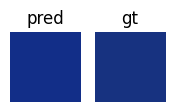

tensor([[2.9941]])
torch.Size([1, 1])
Color loss: 0.00047406915109604597


In [108]:
# get batch and evaluate it
print("Dataloader length:", len(dataloader))  
# We have 100 images in the test set, each of them with 100 pixels, so 10000 1x1 images
# Each batch corresponds to a single image pixel
o, d, color_gt, depth_gt = get_nth_batch(20, dataloader)
o, d, color_gt, depth_gt = o.to(device), d.to(device), color_gt.to(device), depth_gt.to(device)

'''
NerfLightingModule forward pass returns: 
- color_pred: the predicted color of each pixel  (N, 3)
- weights: the accumulated weights of each pixel (N, 1)
- ts: the accumulated transmittance of each pixel (N, 1)
'''
color_pred, weights, ts = nerf(o, d)

color_pred, weights, ts = color_pred.detach().cpu(), weights.detach().cpu(), ts.detach().cpu()
o, d, color_gt, depth_gt = o.detach().cpu(), d.detach().cpu(), color_gt.detach().cpu(), depth_gt.detach().cpu()

show_colors([color_pred[0], color_gt[0]], ['pred', 'gt'])


print(depth_gt)
print(depth_gt.shape)

color_loss = nerf.color_loss(color_pred, color_gt)
print("Color loss:", color_loss.item()) 

Ensure weights sum to one tensor([1.0000])
Ground truth depth 2.994140625


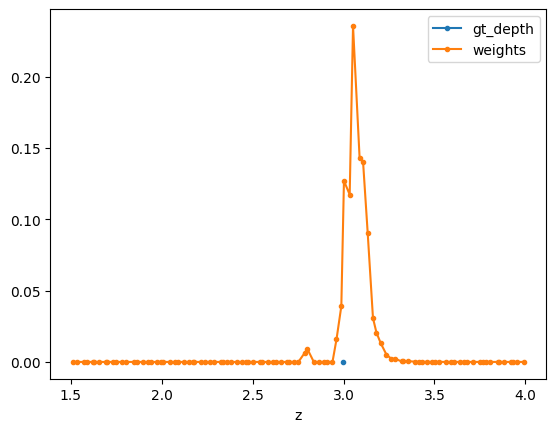

In [110]:
print('Ensure weights sum to one', weights.sum(dim=1))
print('Ground truth depth', depth_gt[0].item())

fig, ax = plt.subplots()

plt.plot([depth_gt[0]], [0], label='gt_depth', marker='.')

ax.plot(ts.detach().numpy(), weights[0].detach().numpy(), label='weights', marker='.')
ax.set_xlabel('z')
ax.legend()
plt.show()



True depth grouth truth 2.994140625
Loss at true depth grouth truth 0.08584444224834442
Loss for different depth ground truths


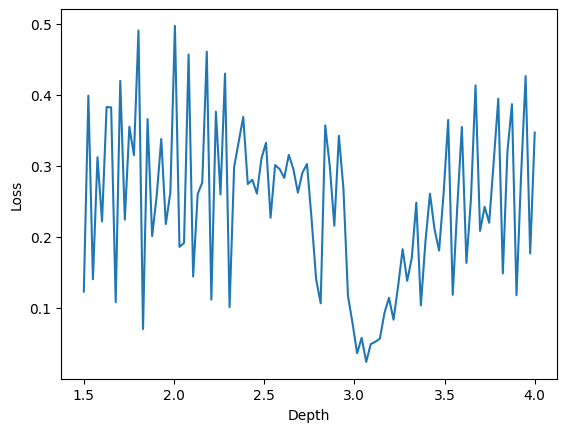

In [153]:

from torch import Tensor

'''
Goal: The loss function should return a scalar value that is minimized when: 
- The weights are high at the ground truth depth
'''
def depth_loss(ts, weights, depth, sigma=0.01) -> Tensor:
    """
    Compute the depth loss for a single pixel.

    Args:
        ts (torch.Tensor): Depth values along the pixel ray (shape: [100]).
        weights (torch.Tensor): Weights along the pixel ray (shape: [1, 100]).
        depth (torch.Tensor): Ground truth depth of the pixel ray (shape: [1, 1]).
        sigma (float): Standard deviation for the Gaussian weighting, default is 1.0.

    Returns:
        torch.Tensor: The computed depth loss (shape: [1]).
    """
    # Compute the intervals between sample points
    dists = ts[1:] - ts[:-1]
    dists = torch.cat([dists, torch.tensor([dists.max()])])  # Last interval is a large number to avoid boundary issues

    # Compute the Gaussian weighting term
    gauss_weight = torch.exp(-0.5 * ((ts - depth) ** 2) / (sigma ** 2))  # Shape: [100]

    # Compute the log probability term
    log_prob = torch.log(weights + 1e-5)  # Shape: [1, 100]

    # Compute the loss by summing over all sampled points, incorporating the intervals
    loss = -torch.sum(log_prob * gauss_weight * dists)  # Shape: []
    
    return loss

print("True depth grouth truth", depth_gt.item())
print("Loss at true depth grouth truth", depth_loss(ts, weights, depth_gt, 0.01).item())

gt_depths = np.linspace(1.5, 4, 100)
print("Loss for different depth ground truths")

losses = []
for gt_depth in gt_depths:
    loss = depth_loss(ts, weights, torch.Tensor([[gt_depth]]), 0.01)
    losses.append(loss.item())

# Plot the losses at the different depths
fig, ax = plt.subplots()
ax.plot(gt_depths, losses)
ax.set_xlabel('Depth')
ax.set_ylabel('Loss')
plt.show()